# Chameleon 3D simulation (I)
For meeting 3/18/2020 & 3/23/2020.

Yukei Murakami, UCB : sterling@astro.berkeley.edu

---------------------------------------

Goals:
- Learn the procedure for 3D simulation
- Build a template of the Chameleon field simulation
- Confirm this method works (comparison vs. Elder et al. 2016)
- Connect to more general case

### Quick Learning resources

- [Fenics Project](https://fenicsproject.org/)<br>
This project 100% relies on this pde solver core package.

- [Fenics Tutorial](https://fenicsproject.org/pub/tutorial/html/ftut1.html)<br>
Not the quickest way to learn, but very long and in-depth tutorial with lots of information.

- [Fenics 2D Linear Poisson example](https://fenicsproject.org/docs/dolfin/1.6.0/python/demo/documented/poisson/python/documentation.html)<br>
Note that there are multiple versions of documentations available online. Currently Dolfin (interface module for Fenics) 1.6.0 is the newest version in March 2020. The version of the documentation can be checked with the version number printed on the left-top corner.

- [Blog article about Electrostatic sim with Fenics](https://comphysblog.wordpress.com/2018/08/26/3d-electrostatics-using-fenics/)<br>
Best blog article for the beginner of Fenics 3D simulation. I initially built a copy of this sample code, and modified parts by parts to learn how it works.

- [Fenics online forum](https://fenicsproject.discourse.group/)<br>
Very active. Quickest way to get your question answered as long as you follow the rule.

- [Variational Formulation of elliptic PDEs](https://www.ljll.math.upmc.fr/ledret/M1English/M1ApproxPDE_Chapter3.pdf)<br>
Technical, but good for learning. Just reading the first few pages is a good way to start learning about this technique.

### References

- [Chameleon Dark Energy and Atom Interferometry (Elder et al. 2016)](https://arxiv.org/abs/1603.06587)
- [Atom-interferometry constraints on dark energy
 (Hamilton et al. 2015)](https://arxiv.org/abs/1502.03888)

## (I) PDE solver core: Fenics

Fenics is an open-source pde solver mainly developed for the finite element analysis. It runs c++ code wrapped by python package. The documentation is sometimes outdated and confusing, but the online forum is very active and main developers (researchers at Cambridge University) typically answer to any reasonable question within a day.

In [13]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## (II) Prepare mesh

In this test example, we model the vacuum space between vacuum chamber and the test source. We set up the boundary condition at the surface. This is only valid for a very strong coupling (=the field reaches the equilibrium very quickly near the surface of heavy objects), and the full solution to the non-approximate model is presented in a separate notebook.

### 3D Modeling: FreeCAD
- open FreeCAD (```$freecad```)
- make 3D model
- subtract objects to create single volume (in this example)
- save as ```filename.step```

### Generate Mesh: GMSH
- open GMSH (```$gmsh```)
- Geometry -> Physical groups -> add -> Surface/Volume: 
Assign physical groups (surfaces and a volume) for each boundary : make sure the assigned number is the index used for the boundary condition. In this case we assign surface #0 for outer sphere, surface #1 for inner sphere, and volume #3 for the volume (we only have one volume).
- Mesh -> Define -> Transfinite -> Line: Define the number of vertex points along the line that defines the surface of sphere (blue curve).
- Mesh -> 3D to generate mesh
- save as ```filename.msh```

### Finalize mesh: dolfin
- ```$dolfin-convert filename.msh filename.xml``` : This will create three files (```*.xml```, ```*_physical_region.xml```, and ```*_facet_region.xml```).
![](./mesh.png)

### Import Mesh

In [14]:
# Import the mesh, identify the subdomains and boundaries
mesh       = fn.Mesh('models/geo2.xml')
markers    = fn.MeshFunction("size_t", mesh, 'models/geo2_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'models/geo2_facet_region.xml')

# Then make a function space and a dx element
dx = fn.Measure('dx', domain=mesh, subdomain_data=markers)
V = fn.FunctionSpace(mesh, 'CG', 1)

# (III) Set up the simulator

To perform the simulation, we need to:

- (1) Define necessary parameters with proper scaling of units
- (2) Set up boundary conditions
- (3) Define pde to be solved
- (4) Run
- (5) Plot & check results.

## (III -1) Parameters

$\Lambda = 2.4\ \mathrm{meV} = 2.4 \times 10^{-3}\ \mathrm{eV}$

$M_{pl} = 2.4 \times 10^{18}\ \mathrm{GeV} = 2.4 \times 10^{27}\ \mathrm{eV}$

$M \approx 10^{-3}M_{pl}$

$$\frac{g}{cm^3} = \frac{\mathrm{kg}/1000}{(10\mathrm{mm})^3} 
= \frac{5.6\times10^{32}\ \mathrm{eV}}{10^3 \mathrm{mm}^3} 
= 5.6 \times 10^{29} \frac{\mathrm{eV}}{\mathrm{mm^3}} 
= 4.3*10^{18}\ \mathrm{eV}^4$$

In [15]:
g_per_cm3_to_ev4 = 4.3 * 10**18

In [16]:
Lambda = 0.1 * 10**-3 # [eV]
Mpl    = 2.4 * 10**27 # [eV]
M      = 10**-3 * Mpl

In [17]:
rho_inner = 2.7 * g_per_cm3_to_ev4 
rho_outer = 7   * g_per_cm3_to_ev4 
rho_vacuum = 6.6 * 10**-17  * g_per_cm3_to_ev4

inner_phi_eq = np.sqrt(Lambda**5 * M / rho_inner)
outer_phi_eq = np.sqrt(Lambda**5 * M / rho_outer)

Check the equilibrium value to see if it makes sense <br>
(we expect $\phi_{eq} \lt 1\mathrm{meV}$ for typical metal):

In [18]:
print("Equilibrium 𝜙 (inner sphere) = {:.2e} eV".format(inner_phi_eq)) #eV
print("Equilibrium 𝜙 (outer sphere) = {:.2e} eV".format(outer_phi_eq)) #eV

Equilibrium 𝜙 (inner sphere) = 4.55e-08 eV
Equilibrium 𝜙 (outer sphere) = 2.82e-08 eV


## (III - 2) Add boundary conditions
- two surfaces: inner and outer (indexed as 1 and 2)
- give constant equilibrium value ($\sqrt{\Lambda^5M/\rho}$) where $\nabla^2\phi=0$

In [19]:
# Set the boundary conditions using the boundary numbers (index)
# specified in Gmsh
inner_boundary = fn.DirichletBC(V, fn.Constant(inner_phi_eq), boundaries, 1)
outer_boundary = fn.DirichletBC(V, fn.Constant(outer_phi_eq), boundaries, 2)
bcs = [inner_boundary, outer_boundary]

## (III - 3) Define pde
- Write down the poisson equation to be solved
- Rewrite the equation in the variational form
- Rescale

The Chameleon Field is expressed (in non-relativistic case)
$$ \nabla^2\phi = V_{\mathrm{eff},\phi}$$
where
$$ V_{\mathrm{eff}} = V(\phi) + A(\phi)\rho_m$$
and
$$ \begin{cases} V(\phi) = \Lambda^4\left(1 + \frac{\Lambda^n}{\phi^n}\right)\\
A(\phi) \approx 1 + \frac{\phi}{M}\end{cases}$$
We take n=1. Then
$$ V_{\mathrm{eff}} = \Lambda^4\left(1 + \frac{\Lambda}{\phi}\right) + \left(1 + \frac{\phi}{M}\right)\rho_m$$

$$ \Rightarrow V_{\mathrm{eff,\phi}} = -\frac{\Lambda^5}{\phi^2} + \frac{\rho_m}{M}$$

$$\Rightarrow -\nabla^2\phi = \frac{\Lambda^5}{\phi^2} - \frac{\rho_m}{M}$$

So the equation to be solved is
$$ -\nabla^2\phi + \frac{\rho_m}{M} = \frac{\Lambda^5}{\phi^2}$$

Using the test function $v$, The variational form of pde becomes

$$ F \equiv \int\left(\nabla\phi \cdot \nabla v + \frac{\rho_m}{M} v\right)\mathrm dx 
- \left(\int\frac{\Lambda^5}{\phi^2}v\mathrm dx  + \int gv\mathrm ds\right) = 0$$

Here $g=0$ and $\mathrm ds$ are added to satisfy $\nabla\phi = 0$ at the boundary ($\mathrm ds$).
To learn about the meaning of this transformation, read Quick Learning Resources.

Note that this equation must be evaluated in natural units. We use 1eV as the unit scale.

In the pde solver, however, the unit of length is \[mm\] (or any unit the 3D mesh is initially modeled in.
To rescale this equation into the proper unit, we introduce the scaling constant $\lambda$ so that

$$ \tilde x = \lambda x$$

where $\lambda = 1.97\times 10^{-4}$ for $x\sim\mathrm{eV}^{-1}$ and $\tilde x\sim \mathrm{mm}$.

This gives the rescaled Poisson equation

$$ -\lambda^2\tilde\nabla^2\phi + \frac{\rho_m}{M} = \frac{\Lambda^5}{\phi^2},$$

Since the units of $\phi$, $M$, and $\rho$ do not have to be rescaled as long as they all are in the same unit scale (i.e. natural units).

Thus, with $\mathrm d x = \lambda^{-1}\mathrm d\tilde x$ and 
$\mathrm ds = \lambda^{-1}\mathrm d\tilde s$,

$$ F \equiv \int\left(\lambda^2\tilde\nabla\phi \cdot \tilde\nabla v + \frac{\rho_m}{M} v\right)\lambda^{-1}\mathrm d\tilde x 
- \left(\int\frac{\Lambda^5}{\phi^2}v\lambda^{-1} \mathrm d\tilde x  + \int gv\mathrm \lambda^{-1} d\tilde s\right) = 0$$

is the final form of the pde for Chameleon field.

In [20]:
scaling = 1.97 * 10**-4

In [21]:
# phi = fn.Function(V)
phi = fn.project(fn.Constant(1),V)
v = fn.TestFunction(V)
f = Lambda**5/phi**2 #fn.Constant(Lambda**5)
g = fn.Constant(0)

a = (fn.inner(fn.grad(phi)*scaling**2,fn.grad(v))+ rho_vacuum*v/M)/scaling*fn.dx
L = f*v/scaling*fn.dx + g*v*fn.ds
F = a-L

## (III - 4): Run

In [22]:
# compute solution
fn.solve(F==0, phi, bcs)

## (III - 5 - i): Extract 1D data (x,0,0)

In [23]:
x = np.linspace(10,49.5, 1000)
y = np.zeros(len(x))
z = np.zeros(len(x))
coords = np.dstack((x, y, z))[0]
coords2 = np.dstack((-x,y,z))[0]
u_line_plus = np.array(list(map(phi, coords)))
u_line_minus = np.array(list(map(phi,coords2)))

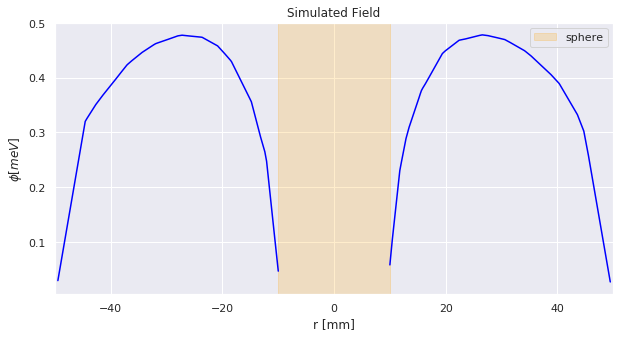

In [24]:
plt.figure(figsize=(10,5))
plt.plot(x,u_line_plus*1000,color='blue')
plt.plot(-x,u_line_minus*1000,color='blue')
plt.xlabel('r [mm]')
plt.ylabel(r'$\phi [meV]$')
plt.title('Simulated Field')
plt.axvspan(-10,10,label='sphere',color='orange',alpha=0.2)
plt.xlim(-50,50)
plt.legend()
plt.show()

In [25]:
# output the 3D result
data3D = fn.File('output/chameleon.pvd')
data3D << phi

## (III - 5 - ii): 3D plot: Paraview
- ```$paraview``` and then use GUI. Python pipeline is available, but it's too much work.

![](output/output2.png)

# (IV) Repeat without inner sphere

## (IV - 1) Run simulation

In [26]:
# Import the mesh
mesh       = fn.Mesh('models/sphere2.xml')
markers    = fn.MeshFunction("size_t", mesh, 'models/sphere2_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'models/sphere2_facet_region.xml')
dx = fn.Measure('dx', domain=mesh, subdomain_data=markers)
V = fn.FunctionSpace(mesh, 'CG', 1)

In [27]:
# Set the boundary conditions 
outer_phi_eq = np.sqrt(Lambda**5 * M / rho_outer)
outer_boundary = fn.DirichletBC(V, fn.Constant(outer_phi_eq), boundaries, 1)
bcs = outer_boundary

In [28]:
# phi = fn.Function(V)
phi = fn.project(fn.Constant(1),V)
v = fn.TestFunction(V)
f = Lambda**5/phi**2
g = fn.Constant(0)
a = (fn.inner(fn.grad(phi)*scaling**2,fn.grad(v))+ rho_vacuum*v/M)/scaling*fn.dx
L = f*v/scaling*fn.dx + g*v*fn.ds
F = a-L

In [29]:
# compute solution
fn.solve(F==0, phi, bcs)

In [31]:
data3D = fn.File('output/empty_sphere.pvd')
data3D << phi

## (IV - 2) Compare with (III - 5)

In [32]:
# extract (x,0,0) data
x3 = np.linspace(-49.5,49.5, 1000)
y3 = np.zeros(len(x3))
z3 = np.zeros(len(x3))
coords3 = np.dstack((x3, y3, z3))[0]
u_line_3 = np.array(list(map(phi,coords3)))

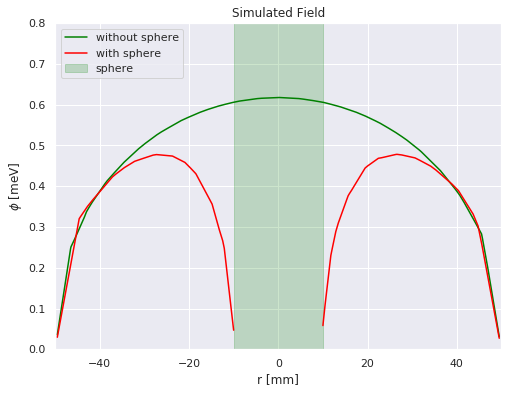

In [41]:
plt.figure(figsize=(8,6))
plt.plot(x3,u_line_3*1000,color='green',label='without sphere')
plt.plot(x,u_line_plus*1000,color='red',label='with sphere')
plt.plot(-x,u_line_minus*1000,color='red')
plt.xlabel('r [mm]')
plt.ylabel(r'$\phi$ [meV]')
plt.title('Simulated Field')
plt.axvspan(-10,10,label='sphere',color='green',alpha=0.2)
plt.xlim(-50,50)
plt.ylim(0,0.8)
plt.legend(loc='upper left')
plt.show()

This plot is a replicated model of Figure 4 in [Elder et al. 2015](https://arxiv.org/abs/1603.06587). 

**It is clear that these two simulations yielded nearly identical results.**

![image.png](Figure4_Elder2015.png)

# (V) Cylinderical Chamber with offset

Now, we use the setup described in Figure 5 in Elder et al. 2015.
![](Figure5_Elder2015.png)

Note that the value of $\Lambda$ is different from previous simulation.

In [42]:
Lambda = 2.4 * 10**-3 # [eV]
Mpl    = 2.4 * 10**27 # [eV]
M      = 10**-3 * Mpl

In [43]:
# Import the mesh, identify the subdomains and boundaries
mesh       = fn.Mesh('models/cylinder.xml')
markers    = fn.MeshFunction("size_t", mesh, 'models/cylinder_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'models/cylinder_facet_region.xml')
dx = fn.Measure('dx', domain=mesh, subdomain_data=markers)
V = fn.FunctionSpace(mesh, 'CG', 1)

# Set the boundary conditions using the boundary numbers
# specified in Gmsh.
inner_phi_eq = np.sqrt(Lambda**5 * M / rho_inner)
outer_phi_eq = np.sqrt(Lambda**5 * M / rho_outer)

inner_boundary = fn.DirichletBC(V, fn.Constant(inner_phi_eq), boundaries, 1)
outer_boundary = fn.DirichletBC(V, fn.Constant(outer_phi_eq), boundaries, 2)
bcs = [inner_boundary,outer_boundary]

# define pde
phi = fn.project(fn.Constant(1),V)
v = fn.TestFunction(V)
f = Lambda**5/phi**2
g = fn.Constant(0)
a = (fn.inner(fn.grad(phi)*scaling**2,fn.grad(v))+ rho_vacuum*v/M)/scaling*fn.dx
L = f*v/scaling*fn.dx + g*v*fn.ds
F = a-L

# compute solution
fn.solve(F==0, phi, bcs)

In [44]:
# output the results to two separate files
data3D = fn.File('output/cylinder.pvd')
data3D << phi

Extract 1D data

In [71]:
x = np.linspace(-60.999,16.03, 1000)
x2 = np.linspace(34.99,60.999, 1000)
y = np.full(len(x),0)
z = np.full(len(x),35)
coords = np.dstack((x, y, z))[0]
coords2 = np.dstack((x2,y,z))[0]
u_line_plus = np.array(list(map(phi, coords)))
u_line_minus = np.array(list(map(phi,coords2)))

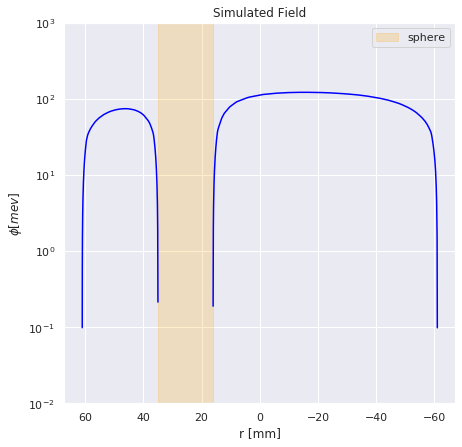

In [76]:
plt.figure(figsize=(7,7))
plt.plot(x,u_line_plus*1000,color='blue')
plt.plot(x2,u_line_minus*1000,color='blue')
plt.xlabel('r [mm]')
plt.ylabel(r'$\phi [mev]$')
plt.title('Simulated Field')
plt.axvspan(16,35,label='sphere',color='orange',alpha=0.2)
plt.yscale('log')
plt.ylim(0.01,1000)
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.show()

This is a replicated result of Figure 7a in Elder et al. 2015 ('offset').

![](Figure7a_Elder2015.png)

![](output/cylinder_slice.png)